In [1]:
%pip install torch torchvision
%pip install umap-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.manifold import TSNE
import umap.umap_ as umap
import re
import numpy as np
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T
from PIL import ImageDraw

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/home/jliang/.conda/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ─── Hyperparameters ──────────────────────────────────────────────────────
IMAGE_SIZE     = 224
IMAGE_CHANNELS = 3
LATENT_DIM     = 128
BATCH_SIZE     = 32
LR             = 1e-4
EPOCHS         = 20
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_IMG_DIR = '/datax/scratch/jliang/dataset_final_small/train/images'
VAL_IMG_DIR   = '/datax/scratch/jliang/dataset_final_small/val/images'
TRAIN_LBL_DIR = '/datax/scratch/jliang/dataset_final_small/train/labels'
VAL_LBL_DIR   = '/datax/scratch/jliang/dataset_final_small/val/labels'
IMG_SIZE = (224, 224)

In [3]:
import re
from PIL import Image, UnidentifiedImageError

class YoloMaskDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size, transform=None):
        # … your existing __init__ up through building self.images/self.labels …
        self.images = sorted(glob(os.path.join(images_dir, "*.*")))
        self.labels = [
            os.path.join(labels_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.images
        ]
        self.transform = transform or T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
        ])
        # optionally: compute global min/max f to normalize later
        freqs = []
        pat = re.compile(r"_f_(?P<fs>[\d\.]+)_(?P<fe>[\d\.]+)")
        for p in self.images:
            m = pat.search(os.path.basename(p))
            if m:
                freqs += [float(m.group("fs").rstrip(".")), float(m.group("fe").rstrip("."))]
        self.fmin, self.fmax = min(freqs), max(freqs)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.labels[idx]

        # — load image & mask (unchanged) —
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        mask = Image.new("L", (W, H), 0)
        draw = ImageDraw.Draw(mask)
        with open(lbl_path) as f:
            for line in f:
                _, xc, yc, w, h = line.strip().split()
                xc, yc, w, h = map(float, (xc, yc, w, h))
                x0 = (xc - w/2) * W
                y0 = (yc - h/2) * H
                x1 = (xc + w/2) * W
                y1 = (yc + h/2) * H
                draw.rectangle([x0, y0, x1, y1], fill=1)

        img_t  = self.transform(img)
        mask_t = self.transform(mask).float()

        # — robustly parse f_start, f_end from filename —
        fname = os.path.basename(img_path)
        name_no_ext, _ = os.path.splitext(fname)
        try:
            # everything after "_f_":
            freqs_str = name_no_ext.split("_f_")[1]
            # split into two parts only
            fstart_str, fend_str = freqs_str.split("_", 1)
            # strip any trailing dots (e.g. "1539.5536." → "1539.5536")
            fstart_str = fstart_str.rstrip(".")
            fend_str   = fend_str.rstrip(".")
            f_start = float(fstart_str)
            f_end   = float(fend_str)
        except Exception as e:
            raise ValueError(f"Could not parse f_start/f_end from '{fname}'") from e

        # — normalize into [0,1], if desired —
        norm_fs = (f_start - self.fmin) / (self.fmax - self.fmin)
        norm_fe = (f_end   - self.fmin) / (self.fmax - self.fmin)
        cond = torch.tensor([norm_fs, norm_fe], dtype=torch.float32)

        return img_t, mask_t, cond

In [4]:
# # ─── Custom Dataset for YOLO Cropped Boxes ─────────────────────────────────
# class YOLOCropDataset(Dataset):
#     def __init__(self, image_dir, label_dir, transform=None):
#         self.samples = []
#         self.transform = transform
#         for img_path in sorted(glob.glob(os.path.join(image_dir, "*.png"))):
#             base = os.path.splitext(os.path.basename(img_path))[0]
#             txt_path = os.path.join(label_dir, base + ".txt")
#             if not os.path.exists(txt_path):
#                 continue
#             img = Image.open(img_path)
#             W, H = img.size
#             with open(txt_path) as f:
#                 for line in f:
#                     parts = line.strip().split()
#                     if len(parts) < 5:
#                         continue
#                     _, x_c, y_c, w, h = parts
#                     x_c, y_c, w, h = map(float, (x_c, y_c, w, h))
#                     x0 = int((x_c - w/2) * W)
#                     y0 = int((y_c - h/2) * H)
#                     x1 = int((x_c + w/2) * W)
#                     y1 = int((y_c + h/2) * H)
#                     self.samples.append((img_path, (x0, y0, x1, y1)))
#         if len(self.samples) == 0:
#             raise RuntimeError("No YOLO crops found. Check image_dir/label_dir.")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, box = self.samples[idx]
#         img = Image.open(img_path).convert("RGB")
#         crop = img.crop(box)
#         if self.transform:
#             crop = self.transform(crop)
#         return crop, img_path

# class YOLOCropDatasetWithPath(YOLOCropDataset):
#     def __getitem__(self, idx):
#         img_path, box = self.samples[idx]
#         img = Image.open(img_path).convert("RGB")
#         crop = img.crop(box)
#         if self.transform:
#             crop = self.transform(crop)
#         return crop, img_path
    
# # ─── Transforms ────────────────────────────────────────────────────────────
# transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
# ])

# # ─── Instantiate Datasets & Loaders ───────────────────────────────────────
# train_dataset = YOLOCropDataset("/datax/scratch/jliang/dataset_final_small/train/images", "/datax/scratch/jliang/dataset_final_small/train/labels", transform)
# test_dataset  = YOLOCropDataset("/datax/scratch/jliang/dataset_final_small/val/images", "/datax/scratch/jliang/dataset_final_small/val/labels", transform)
# train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
# test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
# full_ds = YOLOCropDatasetWithPath(
#     "/datax/scratch/jliang/dataset_final_small/train/images", "/datax/scratch/jliang/dataset_final_small/train/labels", transform
# )
# full_dl = DataLoader(full_ds, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
class MaCVAE(nn.Module):
    def __init__(self, in_ch=3, latent_dim=LATENT_DIM, beta=1.5, cond_dim=2):
        super().__init__()
        # Encoder CNN
        channels = [16, 32, 16, 32, 64, 128, 64, 128]
        layers = []
        c_in = in_ch
        for c_out in channels:
            layers += [
                nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ]
            c_in = c_out
        self.encoder_cnn = nn.Sequential(*layers)

        # Compute flattened dimension
        with torch.no_grad():
            x0 = torch.zeros(1, in_ch, IMAGE_SIZE, IMAGE_SIZE)
            flat_dim = self.encoder_cnn(x0).numel()

        # Bottleneck layers (conditional)
        self.fc_mu     = nn.Linear(flat_dim + cond_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim + cond_dim, latent_dim)

        # Decoder fc (conditional)
        self.fc_dec = nn.Linear(latent_dim + cond_dim, flat_dim)

        # Decoder CNN transpose
        deconv = []
        c_in = channels[-1]
        for c_out in reversed(channels[:-1]):
            deconv += [
                nn.ConvTranspose2d(c_in, c_out, 3, 2, 1, output_padding=1),
                nn.ReLU(inplace=True)
            ]
            c_in = c_out
        deconv.append(nn.ConvTranspose2d(c_in, in_ch, 3, 2, 1, output_padding=1))
        self.decoder_cnn = nn.Sequential(*deconv)

        self.beta = beta

    def encode(self, x, cond):
        h = self.encoder_cnn(x).flatten(1)
        h = torch.cat([h, cond], dim=1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparam(self, mu, logvar):
        sigma = (0.5 * logvar).exp()
        return mu + sigma * torch.randn_like(sigma)

    def decode(self, z, cond):
        zc = torch.cat([z, cond], dim=1)
        h = self.fc_dec(zc).view(z.size(0), -1, 1, 1)
        out = self.decoder_cnn(h)
        out = F.interpolate(
            out,
            size=(IMAGE_SIZE, IMAGE_SIZE),
            mode="bilinear",
            align_corners=False
        )
        return out

    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparam(mu, logvar)
        recon = self.decode(z, cond)
        return recon, mu, logvar

    def loss(self, recon, x, mu, logvar):
        rec = F.mse_loss(recon, x, reduction='mean')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return rec + self.beta * kld

In [6]:
# class MaVAE(nn.Module):
#     def __init__(self, in_ch=3, latent_dim=8, beta=1.5):
#         super().__init__()
#         layers = []
#         # 8 conv layers: two reps of [16→32→64→128]
#         channels = [16,32,16,32,64,128,64,128]
#         c_in = in_ch
#         for c_out in channels:
#             layers += [nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
#                        nn.ReLU(inplace=True)]
#             c_in = c_out
#         self.encoder_cnn = nn.Sequential(*layers)
#         # compute flattened dim
#         with torch.no_grad():
#             x = torch.zeros(1, in_ch, IMAGE_SIZE, IMAGE_SIZE)
#             flat_dim = self.encoder_cnn(x).numel()
#         # bottleneck
#         self.fc_mu     = nn.Linear(flat_dim, latent_dim)
#         self.fc_logvar = nn.Linear(flat_dim, latent_dim)
#         # decoder
#         self.fc_dec    = nn.Linear(latent_dim, flat_dim)
#         # mirror decoder conv-transpose stack
#         deconv_layers = []
#         for c_out in reversed(channels[:-1]):
#             deconv_layers += [
#               nn.ConvTranspose2d(c_in, c_out, 3, 2, 1, output_padding=1),
#               nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         deconv_layers.append(nn.ConvTranspose2d(c_in, in_ch, 3, 2, 1, output_padding=1))
#         self.decoder_cnn = nn.Sequential(*deconv_layers)
#         self.beta = beta

#     def encode(self, x):
#         h = self.encoder_cnn(x).flatten(1)
#         return self.fc_mu(h), self.fc_logvar(h)

#     def reparam(self, mu, log_sigma):
#         sigma = (0.5*log_sigma).exp()
#         return mu + sigma*torch.randn_like(sigma)

#     def decode(self, z):
#         h   = self.fc_dec(z).view(z.size(0), -1, 1, 1)
#         out = self.decoder_cnn(h)                # currently [B, 3, 256,256]
#         out = F.interpolate(
#             out,
#             size=(IMAGE_SIZE, IMAGE_SIZE),
#             mode="bilinear",
#             align_corners=False
#         )                                        # now [B, 3, 224,224]
#         return out

#     def forward(self, x):
#         mu, log_sigma = self.encode(x)
#         z       = self.reparam(mu, log_sigma)
#         recon   = self.decode(z)
#         return recon, mu, log_sigma

#     def loss(self, recon, x, mu, log_sigma):
#         rec = F.mse_loss(recon, x, reduction='mean')
#         kld = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp()) / x.size(0)
#         return rec + self.beta * kld


In [7]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- assuming these are already defined somewhere above: ---
# DATA_DIR, TRAIN_IMG_DIR, TRAIN_LBL_DIR, VAL_IMG_DIR, VAL_LBL_DIR
# IMG_SIZE, BATCH_SIZE, LR, DEVICE, model (MaCVAE instance)

# 1) Datasets + DataLoaders
train_ds = YoloMaskDataset(
    TRAIN_IMG_DIR,
    TRAIN_LBL_DIR,
    IMG_SIZE,
    transform=T.Compose([
        T.Resize(IMG_SIZE),
        T.ToTensor(),
    ])
)
val_ds = YoloMaskDataset(
    VAL_IMG_DIR,
    VAL_LBL_DIR,
    IMG_SIZE,
    transform=T.Compose([
        T.Resize(IMG_SIZE),
        T.ToTensor(),
    ])
)

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [8]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Assumes `model` is your MaCVAE, and `train_dl`, `val_dl`, `optimizer`, `scheduler`,
# `DEVICE`, and `EPOCHS` are already defined.

# ─── Setup ───────────────────────────────────────────────────────────────────
# Assumes you’ve already created:
#   train_dl, val_dl, DEVICE, LR, EPOCHS
# and that train_dl.dataset is your YoloMaskDataset instance

# 1) Instantiate model, optimizer, scheduler
model     = MaCVAE(in_ch=3, latent_dim=128, beta=1.5, cond_dim=2).to(DEVICE)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# 2) Grab fmin/fmax from your dataset so it’s in scope
fmin, fmax = train_dl.dataset.fmin, train_dl.dataset.fmax

# ─── Training Function ─────────────────────────────────────────────────────
def train(model, train_dl, val_dl, optimizer, scheduler, epochs, device, fmin, fmax):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        model.train()
        running_train = 0.0
        for imgs, masks, cond in tqdm(train_dl, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            imgs, masks, cond = imgs.to(device), masks.to(device), cond.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(imgs, cond)
            loss = model.loss(recon, imgs, mu, logvar)
            loss.backward()
            optimizer.step()
            running_train += loss.item() * imgs.size(0)
        avg_train = running_train / len(train_dl.dataset)
        train_losses.append(avg_train)

        # ---- Validate & collect latents ----
        model.eval()
        running_val = 0.0
        mus, freqs = [], []
        with torch.no_grad():
            for imgs, masks, cond in tqdm(val_dl, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False):
                imgs, masks, cond = imgs.to(device), masks.to(device), cond.to(device)
                recon, mu, logvar = model(imgs, cond)
                loss = model.loss(recon, imgs, mu, logvar)
                running_val += loss.item() * imgs.size(0)

                # store for t-SNE later
                mus.append(mu.cpu().numpy())
                # denormalize the f_start (first cond dim)
                fs_batch = cond[:,0].cpu().numpy() * (fmax - fmin) + fmin
                freqs.append(fs_batch)

        avg_val = running_val / len(val_dl.dataset)
        val_losses.append(avg_val)

        # LR scheduler
        scheduler.step(avg_val)

        # logging & checkpoint
        print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "sam_finetuned_cvae.pth")
            print("→ New best model saved.")

    return train_losses, val_losses, np.vstack(mus), np.hstack(freqs)

# ─── Run ─────────────────────────────────────────────────────────────────────
train_losses, val_losses, mus_array, freqs_array = train(
    model, train_dl, val_dl,
    optimizer, scheduler,
    EPOCHS, DEVICE,
    fmin, fmax
)


Epoch 1/20 — Train: 0.2242, Val: 0.0632
→ New best model saved.


Epoch 2/20 — Train: 0.0418, Val: 0.0443
→ New best model saved.


Epoch 3/20 — Train: 0.0318, Val: 0.0333
→ New best model saved.


Epoch 4/20 — Train: 0.0252, Val: 0.0251
→ New best model saved.


Epoch 5/20 — Train: 0.0204, Val: 0.0201
→ New best model saved.


Epoch 6/20 — Train: 0.0168, Val: 0.0155
→ New best model saved.


Epoch 7/20 — Train: 0.0139, Val: 0.0124
→ New best model saved.


Epoch 8/20 — Train: 0.0115, Val: 0.0092
→ New best model saved.


Epoch 9/20 — Train: 0.0097, Val: 0.0071
→ New best model saved.


Epoch 10/20 — Train: 0.0084, Val: 0.0056
→ New best model saved.


Epoch 11/20 — Train: 0.0078, Val: 0.0055
→ New best model saved.


Epoch 12/20 — Train: 0.0076, Val: 0.0052
→ New best model saved.


Epoch 13/20 — Train: 0.0074, Val: 0.0051
→ New best model saved.


Epoch 14/20 — Train: 0.0073, Val: 0.0049
→ New best model saved.


Epoch 15/20 — Train: 0.0073, Val: 0.0048
→ New best model saved.


Epoch 16/20 — Train: 0.0072, Val: 0.0047
→ New best model saved.


Epoch 17/20 — Train: 0.0072, Val: 0.0047
→ New best model saved.


Epoch 18/20 — Train: 0.0071, Val: 0.0046
→ New best model saved.


Epoch 19/20 — Train: 0.0071, Val: 0.0045
→ New best model saved.


Epoch 20/20 — Train: 0.0070, Val: 0.0044
→ New best model saved.


In [9]:
# # ─── Training Loop ─────────────────────────────────────────────────────────
# os.makedirs("/datax/scratch/jliang/reconstructions", exist_ok=True)
# # 3) Training loop (fixed)
# model     = MaVAE().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# for epoch in range(1, EPOCHS+1):
#     model.train()
#     tot_loss = 0.0
#     for crops, _ in train_loader:
#         crops = crops.to(DEVICE)
#         optimizer.zero_grad()
#         recon, mu, logvar = model(crops)
#         # call your model’s loss method (or a standalone function)
#         loss = model.loss(recon, crops, mu, logvar)
#         loss.backward()
#         optimizer.step()
#         tot_loss += loss.item()
#     avg = tot_loss / len(train_loader)
#     print(f"Epoch {epoch}/{EPOCHS} — Avg Loss: {avg:.4f}")
# # 3) Collect all μ’s and freqs
# model.eval()
# mus, freqs = [], []
# with torch.no_grad():
#     for crops, paths in full_dl:
#         crops = crops.to(DEVICE)
#         _, mu, _ = model(crops)               # [B, 128]
#         mus.append(mu.cpu().numpy())
#         # parse frequency out of filename: look for “f_1234.5”
#         for p in paths:
#             m = re.search(r"f_([0-9\.]+)", p)
#             freqs.append(float(m.group(1)) if m else np.nan)

# mus = np.vstack(mus)    # (N, 128)
# freqs = np.array(freqs) # (N,)


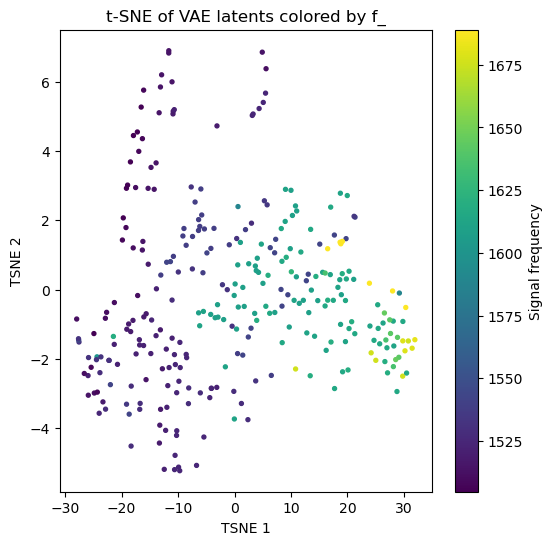

In [10]:
tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(mus_array)

plt.figure(figsize=(6,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=freqs_array, cmap="viridis", s=8)
plt.colorbar(label="Signal frequency")
plt.title("t-SNE of VAE latents colored by f_")
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

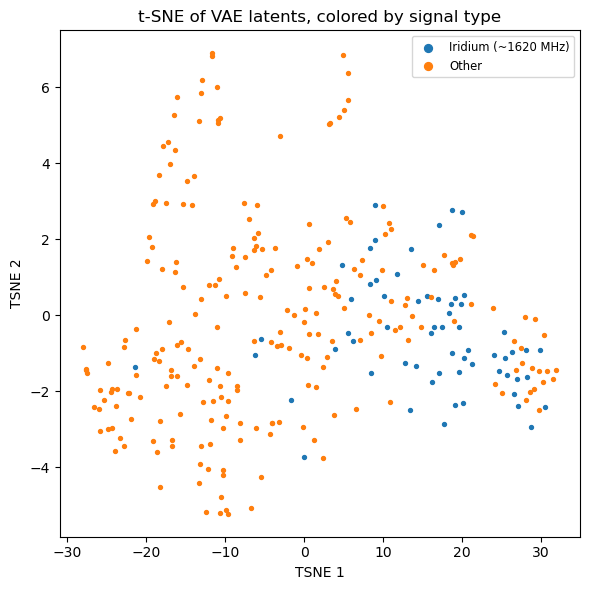

In [11]:
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(mus_array)

# 1) Assign each point to a signal type based on its frequency
labels = []
for f in freqs_array:
    if abs(f - 1575) < 10:           # within ±10 MHz of 1575
        labels.append("GPS (~1575 MHz)")
    elif abs(f - 1620) < 10:         # within ±10 MHz of 1620
        labels.append("Iridium (~1620 MHz)")
    else:
        labels.append("Other")

labels = np.array(labels)

# 2) Plot each category separately for discrete coloring + legend
plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    mask = (labels == lab)
    plt.scatter(
        Z_tsne[mask, 0],
        Z_tsne[mask, 1],
        label=lab,
        s=8
    )

plt.title("t-SNE of VAE latents, colored by signal type")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(markerscale=2, fontsize="small", frameon=True)
plt.tight_layout()
plt.show()


# # 4b) UMAP embedding
# um = umap.UMAP(n_components=2, random_state=42)
# Z_umap = um.fit_transform(mus)

# plt.figure(figsize=(6,6))
# plt.scatter(Z_umap[:,0], Z_umap[:,1], c=freqs, cmap="plasma", s=8)
# plt.colorbar(label="Signal frequency")
# plt.title("UMAP of VAE latents colored by f_")
# plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
# plt.show()